# Let's make a center of people's face image regression

In [4]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

ERROR: Could not find a version that satisfies the requirement torch>=1.7.0 (from fastai>=2.1->fastbook) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
ERROR: No matching distribution found for torch>=1.7.0 (from fastai>=2.1->fastbook)


ModuleNotFoundError: No module named 'scipy._lib._ccallback'

In [ ]:
# dataset from oreil.ly/wHL28
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
# Function to get the center point of face for each data as c1,c1 coordinate
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])


In [ ]:
# Create our datablock
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
               Normalize.from_stats(*imagenet_stats)])

In [ ]:
# Show few examples
dls = biwi.dataloaders(path, num_workers=0)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb,yb = dls.one_batch()
xb.shape, yb.shape 
# xb- independent var, 64 samples of size 240x320 with 3 rgb color i think
# yb- dependent var, 64 samples, 1 tensor of coordinate, what is 2 idk

## We are using Convolutional Neural Network with resnet18 architect

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1)) # model with scale
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi+lo) + lo #activision function
#dls.loss_func # We are using FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)

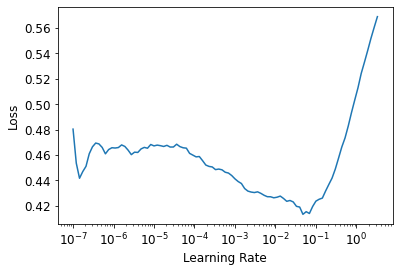

In [26]:
learn.lr_find()

In [36]:
# Looks like lr = e^-2 looks great or like just before lr = e^-1
#lr = between 1/100 and 1/10 but closer to 1/10 
lr = 0.1
learn.fit_one_cycle(5, lr)

KeyboardInterrupt: 

In [ ]:
import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

device_name="/gpu:0"

shape=(int(10000),int(10000))

with tf.device(device_name):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        print(result)

print("\n" * 2)
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)

print("\n" * 2)

In [ ]:
custom_photos = [PILImage.create("image/face"),PILImage.create("image/masked"),PILImage.create("image/hanbok")]
learn.predict(custom_photos)